In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
import os
#import xgboost as xgb
#import lightgbm as lgb
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import gc
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')


In [3]:
os.listdir('dataset-0510/')

['fields.pdf', 'test.csv', 'submit_test.csv', 'train.csv']

In [3]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
data = pd.concat([train, test], axis=0)

In [4]:
train[['parking_area', 'parking_price', 'txn_floor',
       'village_income_median']].isna().sum()

parking_area             56897
parking_price            46065
txn_floor                15902
village_income_median     1142
dtype: int64

In [6]:
train['house_price'] = train['total_price'] - train['parking_price']

In [9]:
from sklearn.linear_model import LinearRegression

In [7]:
train.loc[train['parking_price'].notna(), 'parking_price'].values.reshape(-1,1)

array([[ 81138.88976205],
       [ 61488.56895029],
       [  6721.82305718],
       ...,
       [ 19290.95373523],
       [133729.22686534],
       [ 61488.56895029]])

In [11]:
lm = LinearRegression()
temp = train.loc[(train['total_price'].notna()) & (train['parking_price'].notna())]
lm.fit(temp['total_price'].values.reshape(-1,1), temp['parking_price'].values.reshape(-1,1))
predict = lm.predict(train.loc[train['parking_price'].isna(), 'total_price'].values.reshape(-1,1))



In [14]:
data = pd.concat([train, test], axis=0)
data.drop(['house_price'], axis=1, inplace= True)

In [16]:
def feature_process(df):
    #floor
    df.loc[df['txn_floor'].isna(), 'department'] = 1 
    df.loc[df['txn_floor'].notna(), 'department'] = 0
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    df['avg_height_floor'].fillna(1, inplace = True)
    
    #location
    #df['location_1'] = df.apply(lambda x : int(str(x['city']) + str(x['town']) + str(x['village'])), axis=1)
    df['location_2'] = df.apply(lambda x : int(str(x['city']) + str(x['town'])), axis=1)
    df['city'] = df['city'].astype('category')
    df['location_2'] = df['location_2'].astype('category')
    
    #date
    df['day_between_txn_complete'] = df['txn_dt'] - df['building_complete_dt']
    df['year_between_txn_complete'] = df['day_between_txn_complete'] / 365
    
    #area
    
    
    #df['land*bulid_area'] = df['land_area'] * df ['building_area']
    df['land/bulid_area'] = df['land_area'] / df ['building_area']
    df['land+bulid_area'] = df['land_area'] + df ['building_area']

    #parking
    #df['parking_price_every_area'] = df['parking_price'] / df['parking_area']
    #df['parking_way'] = df['parking_way'].astype('category')
    
    #population
    
    #soical rate
    df['positive_born_rate']     = df['born_rate'] - df['death_rate']
    df['positive_born_rate']     = df['born_rate'] / df['death_rate']
    df['positive_marriage_rate'] = df['marriage_rate'] - df['divorce_rate']
    df['positive_marriage_rate'] = df['marriage_rate'] / df['divorce_rate']
    
    #building   #building_type = 4 is house
    df['building_type'] = df['building_type'].astype('category')
    df['building_use'] = df['building_use'].astype('category')
    df['building_material'] = df['building_material'].astype('category')
    
    #degree rate
    df['all_degree'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] + df['elementary_rate']
    df['junior_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] + df['jobschool_rate'] + df['junior_rate'] 
    df['jobschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate'] +  df['jobschool_rate']
    df['highschool_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate'] + df['highschool_rate']
    df['bachelor_above_rate'] = df['doc_rate'] + df['master_rate'] + df['bachelor_rate']
    df['master_above_rate'] = df['doc_rate'] + df['master_rate'] 
    
    #interection
    df['inter_btw_parking_building'] = df.apply(lambda x : int(str(x['building_type']) + str(x['parking_way'])), axis=1)
    df['inter_btw_parking_building'] = df['inter_btw_parking_building'].astype('category')
    
    #groupby encoding
    
    category_cols  = ['city', 'building_material', 'location_2']
    numerical_cols = ['building_area', 'land_area']
    statistics = ['mean', 'median', 'max', 'min']
    for category in category_cols:
        for numerical in numerical_cols:
            for stat in statistics:
                df[numerical + '_' + stat + '_gb_' + category] = df.groupby([category])[numerical].transform(stat)
                df[numerical + '_diff_' + stat + '_gb_' + category] = df[numerical] - df[numerical + '_' + stat + '_gb_' + category]
    

    
    #Impute missing value
    #df['village_income_median'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.median()))
    df['village_income_mean'] = df.groupby(['city', 'town'])['village_income_median'].transform(lambda x : x .fillna(x.mean()))
    
    df['parking_price'] = df.groupby(['building_type', 'parking_way'])['parking_price'].transform(lambda x : x.median())

    #df['department_building_type'] = df.apply(lambda x : int(str(x['department']) + str(x['building_type'])), axis=1)
    #df['department_building_type'] = df['department_building_type'].astype('category')
    
    #Polynomail feature
    
    
    #useless cols
    df.drop(['village', 'town', 'parking_area'], axis = 1, inplace = True)
    df.drop([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i], axis = 1, inplace = True)
    return df

In [17]:
data = feature_process(data)
FE_train = data[:60000]
FE_test = data[60000:]
FE_train.to_csv('FE_train.csv', index = False)
FE_test.to_csv('FE_test.csv', index = False)

In [15]:
len(FE_train.columns), len(FE_test.columns)

(263, 263)

In [14]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 277 entries, building_id to parking_area_gb_city_town
dtypes: category(5), float64(74), int64(197), object(1)
memory usage: 124.8+ MB


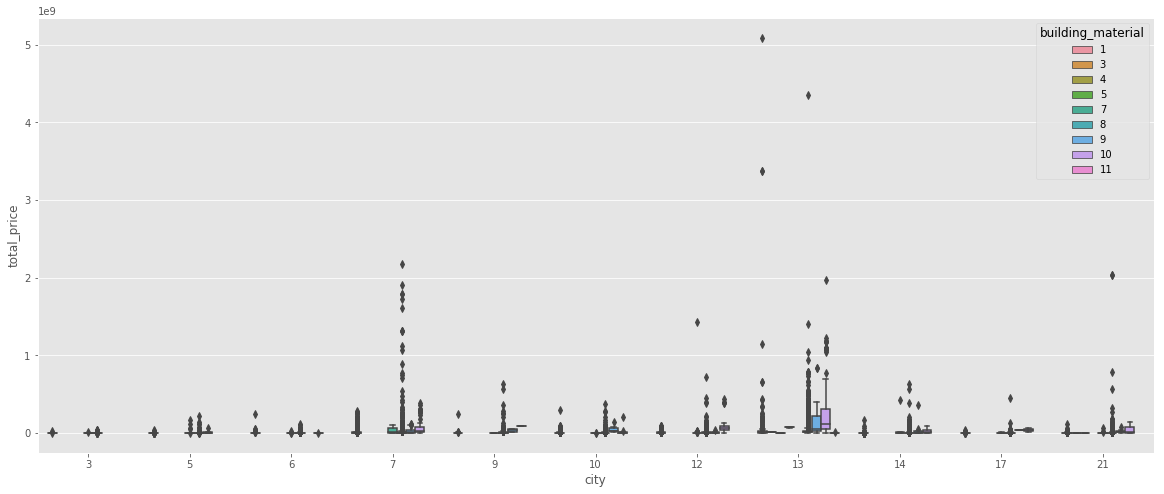

In [25]:
fig = plt.figure(figsize=(20,8))
sns.boxplot(x = train['city'], y = train['total_price'], hue = train['building_material'])

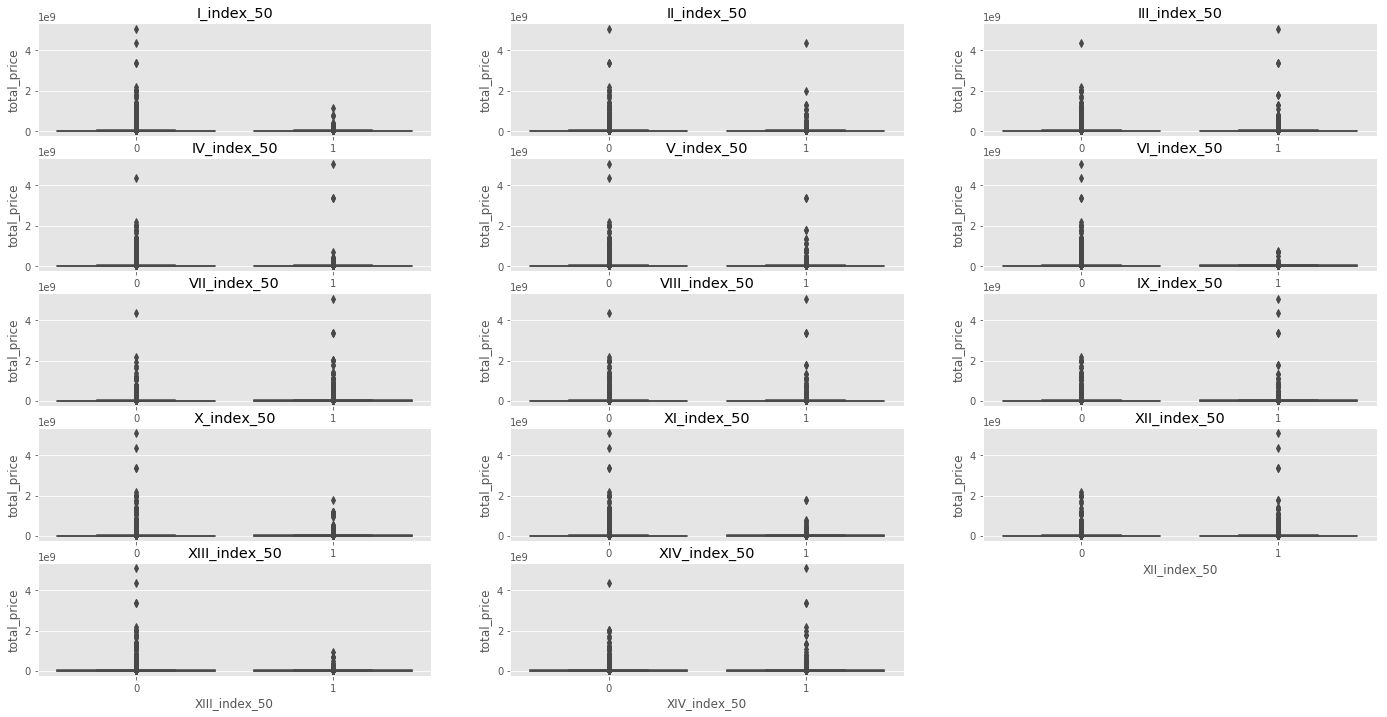

In [165]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_50')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], train['total_price'])

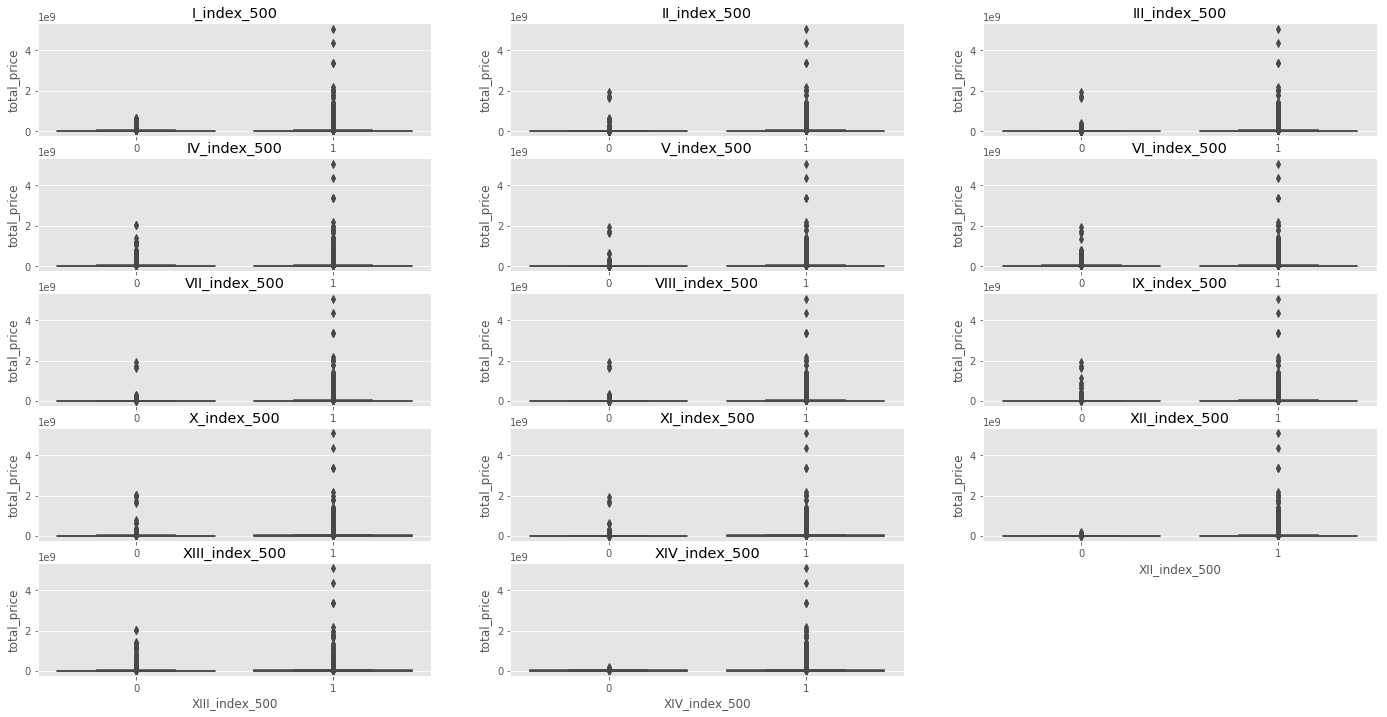

In [170]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], train['total_price'])

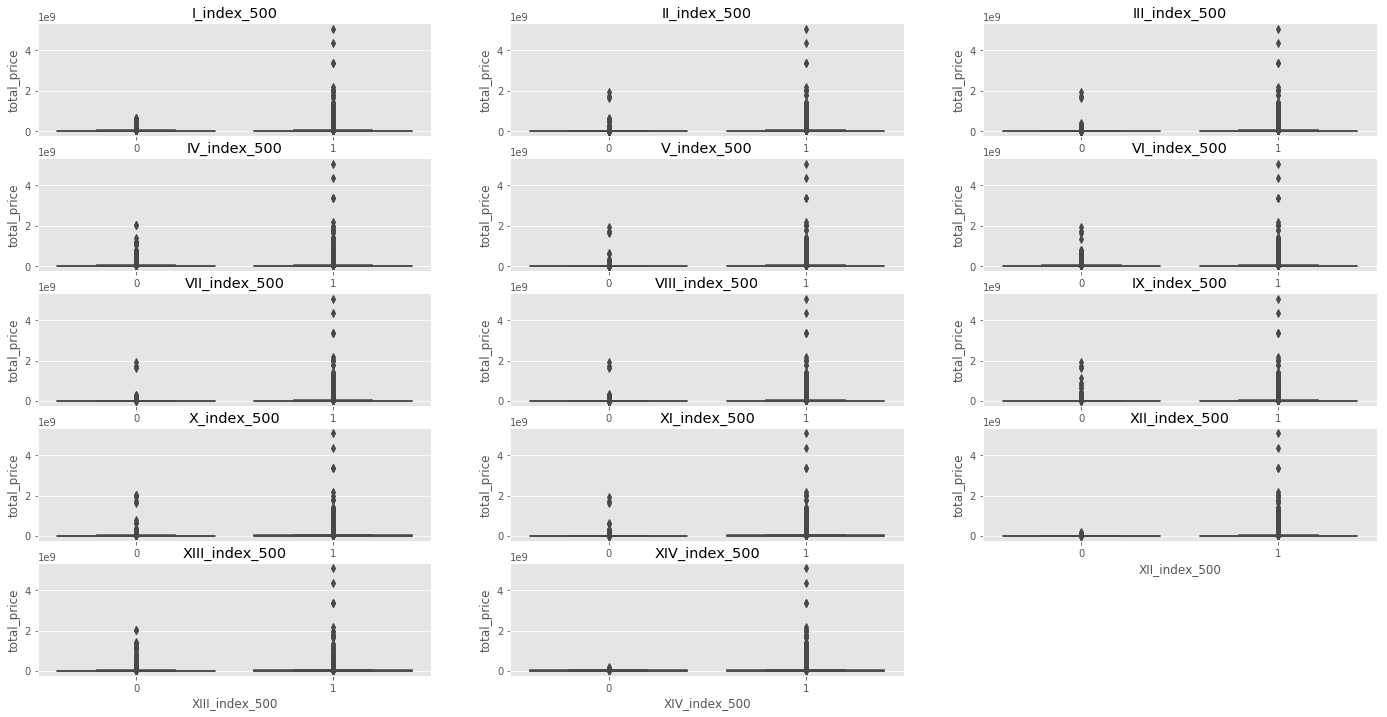

In [167]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_500')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], train['total_price'])

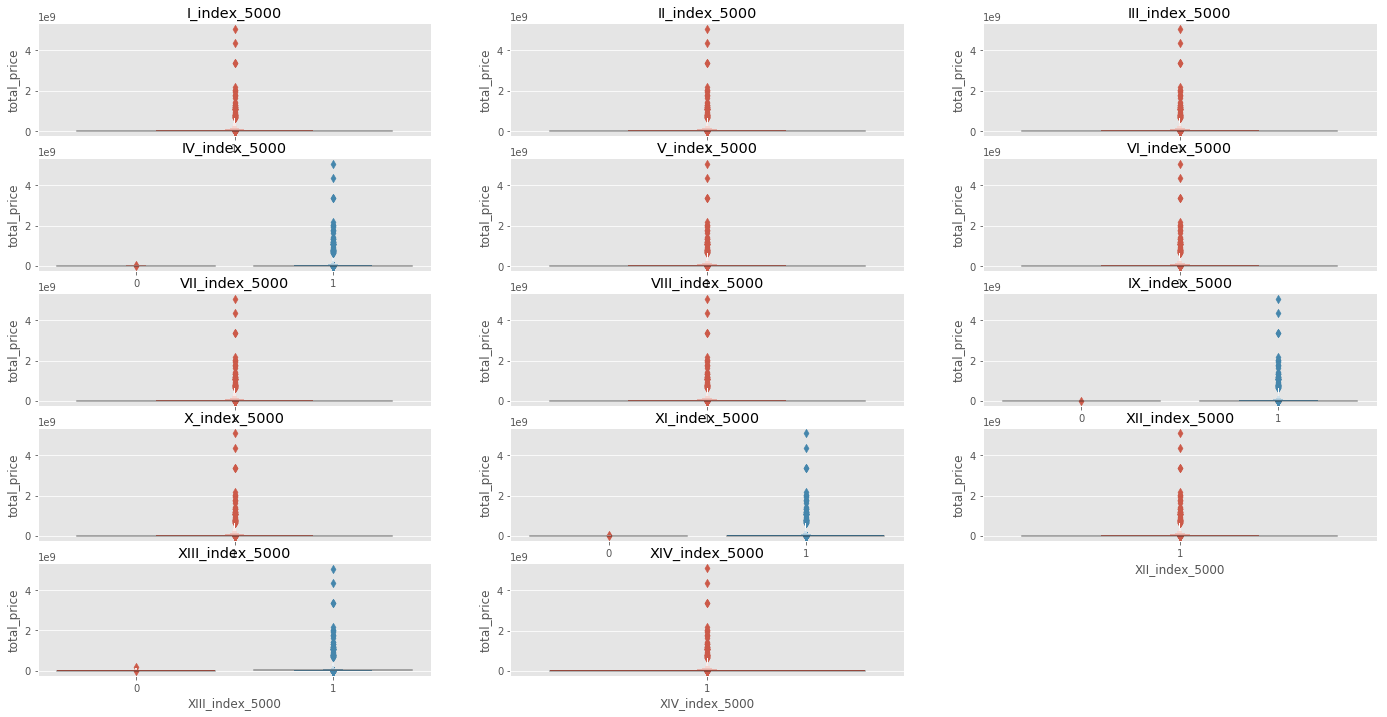

In [176]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_5000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxenplot(train[col], train['total_price'])

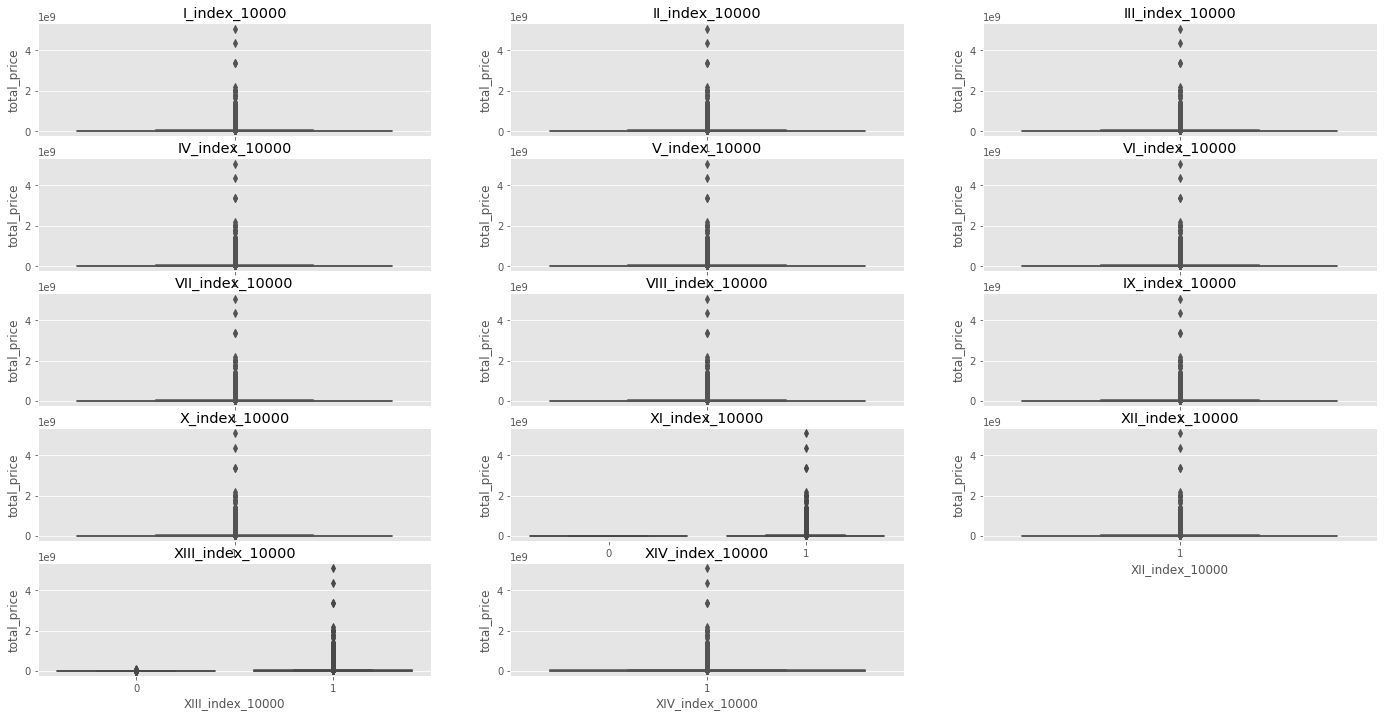

In [169]:
fig = plt.figure(figsize= (24,12))
for index, col in zip(range(14), [i for i in train.columns if i.endswith('_index_10000')]):
    ax = fig.add_subplot(5,3, index+1)
    ax.set_title(col)
    sns.boxplot(train[col], train['total_price'])

In [175]:
len([i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i])

22